# DATA PREPARATION

### Merging 
proposizionalizzazione

In [1]:
import pysal
import numpy
import scipy
import pandas
import shapefile as shp
import matplotlib.pyplot as plt


fig_size = [10, 10]
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')
%matplotlib inline
pandas.set_option('display.max_rows', 100, "display.max_columns", 100)

In [2]:
db_blocks_people = pysal.open('./dataset/Data/CLT_BlockGroups_Attr.dbf','r')
df_blocks_people = pandas.DataFrame(db_blocks_people[:], columns=db_blocks_people.header)
print df_blocks_people.shape
df_blocks_people.ix[:3]

(485, 18)


,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,ARPCIncome,ARPerHEdu,ARPerWork,ARPerMI5L,ARPerRMI5L,ARPer3MU
0,37,119,005301,1,371190053011,Block Group 1,G5030,S,3692032,0,+35.2582845,-080.8060757,12375.0,7.486865,69.674647,73.998045,68.132942,82.098765
1,37,119,001400,2,371190014002,Block Group 2,G5030,S,1051009,0,+35.2437169,-080.8024062,39139.0,13.474495,83.140878,55.172414,25.689655,27.016645
2,37,119,001200,3,371190012003,Block Group 3,G5030,S,2111630,6882,+35.2274080,-080.7930404,60271.0,9.193122,89.514066,23.713927,12.421581,3.436019
3,37,119,005847,1,371190058471,Block Group 1,G5030,S,2937830,19993,+35.0855266,-080.7642117,70142.0,13.423352,84.393758,20.808081,0.000000,0.000000


In [3]:
db_blocks = pysal.open('./dataset/Data/CLT_Blocks_Attr.dbf','r')
df_blocks = pandas.DataFrame(db_blocks[:], columns=db_blocks.header)
df_blocks.ix[:1]

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF
0,37,119,005401,2028,371190054012028,N,0.000116,97.590361,0.047322,3.614458,84.615385,33.333333
1,37,119,004600,2025,371190046002025,N,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
# BLOCKID10 unique length 15
# first digit of BLOCKCE refers to the BLOCK GROUP
attr = "BLOCKCE"
print df_blocks.shape
print "number of unique blocks:", len(set([ str(i) for i in df_blocks[attr].tolist()]))

(8354, 12)
number of unique blocks: 315


In [5]:
db_business = pysal.open('./dataset/Data/CLT_Business_Attri.dbf','r')
df_business = pandas.DataFrame(db_business[:], columns=db_business.header)

print(len(df_business))
df_business[:1]

24375


,OBJECTID,Join_Count,ID,NUM_ADDR,NUMADD_M,Match_,year_,Quarter,NAICS,CntCode,legalCode,tradeNm,MarchEmp,tot_Addr,TXT_JURIS,CDE_ZIP1,Web_Addr,PhyStr1,PhyStr2,PhyStrSN,PhyStrWN,PhyCity,phyZip,PhyState,taxAddr1,taxAddr2,taxCity,taxState,taxZip,mailStr1,mailStr2,MailCity,mailSt,mailZip,geoLon,geoLat,X_Coord,Y_Coord,PID_oldgeo,PID,taxpid,gisacres,zone_id,Block_id,LandUse,PlanTypeID,PlanDesc,FlagFlood,FlagProt,cenX,cenY,city_id,county_id,uid,LandVal,newX0,newY0,newX,newY,NRBld08,newX1,newY1,notes,ID2006,SIC05,Problem,TradeName,AddUpdated,nexX2,nexY2,extra_Info,NewAdd11,emp_old,tempadd,StrMapped,WHOLESTNAM,WHOLESTN_F,ST_NAME,ST_NAME_LA,StrMapID
0,18421,1,48567.0,339743,339743,g,2008.0,1.0,531210.0,119,VIKING RESOURCES INC,V R BUSINESS BROKERS,4.0,17250 LANCASTER HY,CHARLOTTE,28277,,17250 LANCASTER HWY,SUITE 601,17250,LANCASTER HWY,CHARLOTTE,28277,NC,17250 LANCASTER HWY STE 601,,CHARLOTTE,NC,28209.0,17250 LANCASTER HWY STE 601,,CHARLOTTE,NC,28209,-080.851326,35.014948,1445679.0,465953.0,291665,22304C99,22304212,5.351901,10934,371190058182033,18,16,Office_Low,0,0,1445635,466071,1,119,291665,30000,1445679,465953,0,0,1,0,0,,0.0,0.0,0,V R BUSINESS BROKERS,0,0,0,0,0,4,0,0,LANCASTER HWY,LANCASTER HY,LANCASTER,HY,28294


In [6]:
db_crimes = pysal.open('./dataset/Data/CrimeIncident_CMPD_2010.dbf','r')
df_crimes = pandas.DataFrame(db_crimes[:], columns=db_crimes.header)
print df_crimes.shape
df_crimes.ix[:0]

(67595, 53)


,OBJECTID_1,OBJECTID,Complaint_,ComplainNo,Block_No,Direction,Street_Nam,Street_Typ,Suffix,Apt_No,City,State,ZipCode,X,Y,Division,Report_Dat,Location_D,Location_T,Incident_F,Incident_T,Place1,Place2,CSS_Called,Clearance_,Clearance1,Case_Statu,Reporting_,Follow_Up_,NIBRS_Hi_C,rp_last_na,rp_first_n,rp_middle_,rp_Block_N,rp_Directi,rp_Street_,rp_Street1,re_Suffix,rp_Apt_No,rp_City,rp_State,rp_ZipCode,F41,F42,OID_,Complaint1,Complain_1,Attempt,NIBRScateg,NIBRSclass,NOCcode,strMapped,WHOLESTNAM
0,1,1,2.010010e+13,20100101000504,1120.0,,SCALEYBARK,RD,,,CHARLOTTE,NC,,1444054.0,523228.0,26.0,01/01/2010 0005,Location of occurrence,Indoors,01/01/2010 0005,,Residential,Apartment/Duplex Private Res,N,Normal Clearance - Cleared by Arrest,1/1/2010,Close/Cleared,Charlotte-Mecklenburg Police Department,26-WESTOVER DIVISION,Simple Assault,ISENHOUR,#3907,,,,,,,,,,,,,0,2.010010e+13,20100101000504,Completed,Assault / Assault: on Government Officer or Em...,Simple Assault,13B,1,SCALEYBARK RD


#### to rem
blocks_in_block  = [str(i)[0:12] for i in df_blocks["BLOCKID10"].tolist()]
blocks_in_busin  = [str(i) for i in df_business["Block_id"].tolist()]
blocks_in_crimes = [str(i)[0:12] for i in df_crimes["BLOCKID10"].tolist()]
blocks_in_groups = [str(i) for i in df_blocks_people["GEOID10"].tolist()]

set_blocks_in_block  = set(blocks_in_block)
set_blocks_in_busin  = set(blocks_in_busin)
set_blocks_in_crimes = set(blocks_in_crimes)
set_blocks_in_groups = set(blocks_in_groups)

def inspect(set_blocks_in_block, blocks_in_groups):
    print len(blocks_in_crimes), "blocks \t set:", len(set_blocks_in_crimes)
    print len(blocks_in_groups), "blocks \t set:", len(set_blocks_in_groups)
    print ""
    print len(set(blocks_in_crimes) & set(blocks_in_groups)), " in comune"
    
inspect(blocks_in_crimes, blocks_in_groups)

#### blocks in crime that are both in df_blocks and in df_blocks_people
len([str(i) for i in df_crimes["BLOCKID10"].tolist() if i in set_blocks_in_block and i[0:12] in set_blocks_in_groups])

print len([str(i) for i in df_crimes["BLOCKID10"].tolist()])
len(set([str(i) for i in df_crimes["BLOCKID10"].tolist()]))

In [7]:
# add column in crime dataframe for BLOCKID10 - taken from busine dataframe
# add "not found" where BLOCKID10 could not be found
street2block = df_business.set_index('ST_NAME')["Block_id"].to_dict()
df_crimes["BLOCKID10"] = df_crimes["Street_Nam"].map(lambda street: street2block.get(street, "not found"))
df_crimes.shape

(67595, 54)

In [8]:
# remove rows where BLOCKID10 is "not found"
df_crimes = df_crimes[df_crimes["BLOCKID10"] != "not found"]
# df_crimes = df_crimes.reset_index(drop=True)
df_crimes.shape

(50455, 54)

In [9]:
# adding df_blocks' and df_blocks_people's columns of interest
block2group = {}
for index, row in df_blocks_people.iterrows():
    block2group[str(row["GEOID10"])] = {
        "ARPCIncome": row["ARPCIncome"],
        "ARPerHEdu":  row["ARPerHEdu"],
        "ARPerWork":  row["ARPerWork"],
        "ARPerRMI5L": row["ARPerRMI5L"],
        "ARPer3MU":   row["ARPer3MU"]}

block2block = {}
for index, row in df_blocks.iterrows():
    block2block[str(row["BLOCKID10"])] = {
        "ARPopDen":   row["ARPopDen"],
        "ARPerAA":    row["ARPerAA"],
        "ARHeteInx":  row["ARHeteInx"],
        "ARPerM1724": row["ARPerM1724"],
        "ARPerHOwn":  row["ARPerHOwn"],
        "ARPerSF":    row["ARPerSF"]}

df_crimes["ARPCIncome"] = df_crimes["BLOCKID10"].map(lambda block_id: block2group.get(block_id[0:12], {}).get("ARPCIncome", "NF"))
df_crimes["ARPerHEdu"]  = df_crimes["BLOCKID10"].map(lambda block_id: block2group.get(block_id[0:12], {}).get("ARPerHEdu", "NF"))
df_crimes["ARPerWork"]  = df_crimes["BLOCKID10"].map(lambda block_id: block2group.get(block_id[0:12], {}).get("ARPerWork", "NF"))
df_crimes["ARPerRMI5L"] = df_crimes["BLOCKID10"].map(lambda block_id: block2group.get(block_id[0:12], {}).get("ARPerRMI5L", "NF"))
df_crimes["ARPer3MU"]   = df_crimes["BLOCKID10"].map(lambda block_id: block2group.get(block_id[0:12], {}).get("ARPer3MU", "NF"))

df_crimes["ARPopDen"]   = df_crimes["BLOCKID10"].map(lambda block_id: block2block.get(block_id, {}).get("ARPopDen", "NF"))
df_crimes["ARPerAA"]    = df_crimes["BLOCKID10"].map(lambda block_id: block2block.get(block_id, {}).get("ARPerAA", "NF"))
df_crimes["ARHeteInx"]  = df_crimes["BLOCKID10"].map(lambda block_id: block2block.get(block_id, {}).get("ARHeteInx", "NF"))
df_crimes["ARPerM1724"] = df_crimes["BLOCKID10"].map(lambda block_id: block2block.get(block_id, {}).get("ARPerM1724", "NF"))
df_crimes["ARPerHOwn"]  = df_crimes["BLOCKID10"].map(lambda block_id: block2block.get(block_id, {}).get("ARPerHOwn", "NF"))
df_crimes["ARPerSF"]    = df_crimes["BLOCKID10"].map(lambda block_id: block2block.get(block_id, {}).get("ARPerSF", "NF"))

df_crimes.shape

(50455, 65)

In [10]:
# removing all rows that don't have census attributes
# because some BLOCKID10 don't exists in df_blocks and df_block_people
df_temp = df_crimes[df_crimes["ARPopDen"] != "NF"]
df_crimes_and_census = df_temp[df_temp["ARPCIncome"] != "NF"]
df_crimes_and_census.shape

(19106, 65)

write to file
df_crimes_and_census.to_csv("dataset/prova.csv", sep='\t')

In [11]:
# find nearest n business/POI for a crime
crime_points    = numpy.array(pysal.open('./dataset/Data/CrimeIncident_CMPD_2010.shp', 'r'))
business_points = numpy.array(pysal.open('./dataset/Data/CLT_Business_Attri.shp', 'r'))
mall_points     = numpy.array(pysal.open('./dataset/Data/POI_Malls.shp', 'r'))
walmart_points  = numpy.array(pysal.open("./dataset/Data/POI_WALMART.shp", 'r'))
drinking_points = numpy.array(pysal.open("./dataset/Data/POI_AlcoholicDrinkingPlaces_CLIP.shp", 'r'))
hotels_points   = numpy.array(pysal.open("./dataset/Data/POI_HotelsMotels.shp", 'r'))
park_points     = numpy.array(pysal.open("./dataset/Data/POI_ParknRideFacilities.shp", 'r'))

business_name = [row["TradeName"] for i, row in df_business.iterrows()]
mall_name     = ["mall" for i in mall_points]
walmart_name  = ["walmart" for i in walmart_points]
drinking_name = ["drinking" for i in drinking_points]
hotels_name   = ["hotels" for i in hotels_points]
park_name     = ["park" for i in park_points]

names = business_name + mall_name + walmart_name + drinking_name + hotels_name + park_name
points = numpy.concatenate((business_points, mall_points, walmart_points, drinking_points, hotels_points, park_points))

In [12]:
closest_POI = []
kd_tree = scipy.spatial.cKDTree(points, leafsize=100)
for point in crime_points:
    neighborhood = kd_tree.query(point, k=4)
    closest_POI.append( [str(names[neighbor]) for neighbor in neighborhood[1]] )

# closest_POI -> for each crime iits neighbourhood

for i, row in df_crimes_and_census.iterrows():
    print i

In [13]:
for i, row in df_crimes_and_census.iterrows():
    df_crimes_and_census.set_value(i,'First_POI', closest_POI[i][0])
    df_crimes_and_census.set_value(i,'Second_POI', closest_POI[i][1])
    df_crimes_and_census.set_value(i,'Third_POI', closest_POI[i][2])
    df_crimes_and_census.set_value(i,'Fourth_POI', closest_POI[i][3])

In [14]:
# keeping only some crimes' columns
col2keep = [
    "BLOCKID10",    # block ID
    "First_POI",    # first closest POI
    "Second_POI",   # second closest POI
    "Third_POI",    # third closest POI
    "Fourth_POI",   # fourth closest POI
    "ARPCIncome",   # percapital Income; type: real, length 18
    "ARPerHEdu",    # percentage of education with high school and above
    "ARPerWork",    # percentage of population employed
    "ARPerRMI5L",   # percentage of population who rent and moved in less than 5 years ago
    "ARPer3MU",     # percentage of home with 3 or more multiple unit structure
    "ARPopDen",     # population density; type: real, length 18
    "ARPerAA",      # percentage of population who are American African
    "ARHeteInx",    # heterogeneity index for races
    "ARPerM1724",   # percentage of population who are 17-24 males
    "ARPerHOwn",    # percentage of population who own home
    "ARPerSF",      # percentage of families with single parent
    "NIBRSclass",   # type of crime i guess
    "Attempt",      # completed, ecc
    "Case_Statu",   # further investigation, close/cleared, ecc
    "Clearance_",   # open, normal clearance/cleared by arrest, ecc
    "Place1",       # residential, open area, commercial place, retail
    "Place2",       # private residence, street/highway, ecc
    "Location_T",   # indoors or outdoors
    "Report_Dat",   # date
    "Street_Nam"    # street
]

# 19106 rows × 25 columns
df_crimes_and_census = df_crimes_and_census[col2keep]
df_crimes_and_census.shape

(19106, 25)

In [15]:
df_crimes_and_census

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
0,371190032011003,CHARLOTTE WOOD APARTMENTS,CAROLINA FIRST AID & SAFETY,WILDWOOD APARTMENTS,MT ZION HOLINESS CHURCH,23826,22.5136,93.0147,30.6122,20.3501,0.000151339,7.42574,0.549505,8.91089,14,38,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Apartment/Duplex Private Res,Indoors,01/01/2010 0005,SCALEYBARK
12,371190015041006,UNITED TREATMENT FACILITY,LINKS AT CITI SIDE,STRAIGHT LINE PAVEMENT MARKING,JAMES D MCDUFFIE AGENT,17393,14.6895,80.3054,28.8553,28.1577,0.00013986,54.1667,0.53125,0,72.7273,36.3636,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Apartment/Duplex Private Res,Outdoors,01/01/2010 0110,CITISIDE
15,371190001001020,hotels,ILLUM'E,OMNI CHARLOTTE HOTEL,THE RITZ CARLTON HOTEL COMPANY LLC,106794,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Weapon Law Violations,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Open Area,Street/Highway,Outdoors,01/01/2010 0118,COLLEGE
17,371190019113000,INTERACTIVE COMMUNICATIONS,TODDLETOWN KIDS INC,HOMEPLACE MASONRY INC,G T M GENERAL CONTRACTING INC,20216,7.36961,72.3454,28.0559,14.4354,0.000199563,37.3072,0.685781,4.76858,43.9689,33.0739,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Private Residence,Indoors,01/01/2010 0140,WALTERBORO
18,371190051001003,CHARLOTTE MANOR LLC,NORTHEASTERN PLUMBING CO,MURPHY'S HOME REMODELING,ST JAMES HOLINESS CHURCH,7172,11.138,54.6798,50.2427,10.4126,0,0,0,0,0,0,Simple Assault,Completed,Further Investigation,Open,Residential,Private Residence,Outdoors,01/01/2010 0141,MCARTHUR
22,371190042003001,ENDERLY PARK RECREATION CTR,GOOD HOPE MISSIONARY BAPTIST,KAMIT NATURAL FOODS,PARKVIEW,6203,21.7842,39.4886,69.378,6.03774,0.000137641,72.5,0.455,10,46.6667,26.6667,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Private Residence,Indoors,01/01/2010 0148,CLAY
23,371190005003013,GREENS LUNCH INC,V LOUNGE,drinking,TORRENCE DOCUMENT SERVICES,33897,22.045,79.1171,48.3929,52.7738,0.000282275,43.2432,0.520088,2.7027,87.5,25,Damage/Vandalism Of Property,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Bar/Tavern/Nightclub,Outdoors,01/01/2010 0149,4TH
27,371190038023020,FITNESS TOGETHER,DMR ARCHITECT,DUCKSWORTHS CHEESESTEAKERY,CC SELF TAN LLC,16246,0,74.2857,12.7072,0,0.000106519,55.814,0.51271,0,47.3684,21.0526,Affray,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Bar/Tavern/Nightclub,Parking Lot,01/01/2010 0200,WOODLAWN
29,371190001001020,COYOTE UGLY SALOON,drinking,MAID IN MECKLENBURG,TRYON HOUSE APARTMENTS,106794,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Restaurant/Diner/Coffee Shop,Indoors,01/01/2010 0208,COLLEGE
31,371190013001011,WEESIES HOME CARE SERVICES INC,A MILLER ROOFING,GUARANTEED ROOFING CO,A MILLER CLEANING SVC,18560,13.1707,71.9573,36.8247,19.5424,0.000165663,27.2727,0.512397,0,77.7778,16.6667,Aggravated Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Private Residence,Outdoors,01/01/2010 0209,MEADOW


In the following we show some simple statistic about each variable:
- **Count**: Describes the number of not null values;
- **Unique**: Describes the number of unique values;
- **Top**: Describes the mode (in the case of multiple mode only one is shown)
- **Freq**: Describe the frequency of the returned top value


In [16]:
df_crimes_and_census.describe()

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
count,19106,19106,19106,19106,19106,19106.0,19106.000000,19106.000000,19106.000000,19106.0,19106.0,19106.0,19106.0,19106.0,19106.0,19106.0,19106,19106,19106,19106,19106,19106,19106,19106,19106
unique,741,3798,3895,4165,4292,181.0,180.000000,180.000000,168.000000,153.0,623.0,385.0,463.0,287.0,297.0,275.0,52,2,4,10,5,67,5,18673,1094
top,371190047001015,MARMI,hotels,CARLYLE & COMPANY,LIZ CLAIBORNE,18560.0,13.170732,71.957295,36.824697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Theft From Motor Vehicle,Completed,Inactive,Open,Residential,Private Residence,Indoors,05/01/2010 1631,TRADE
freq,787,215,311,215,215,1058.0,1058.000000,1058.000000,1058.000000,1591.0,5727.0,7570.0,7663.0,9086.0,6868.0,7044.0,2523,18413,9803,11520,8414,3950,8451,3,787


In [17]:
df_crimes_and_census["ARPCIncome"].replace(0, numpy.nan).mean()
df_crimes_and_census["ARPCIncome"].replace(0, numpy.nan).mode()

df_crimes_and_census["ARPCIncome"].replace(0, numpy.nan).mean()
df_crimes_and_census["ARPCIncome"].replace(0, numpy.nan).mode()


0    18560.0
dtype: float64

In [18]:
attr = "ARPer3MU"
print df_crimes_and_census[attr].mean()
print df_crimes_and_census[attr].replace(0, numpy.nan).mean()
print ""
print df_crimes_and_census[attr].mode()
print df_crimes_and_census[attr].replace(0, numpy.nan).mode()

35.7747529807
39.0244036797

0    0
dtype: object
0    19.542421
dtype: float64


In [19]:
print "papparjà"

papparjà


In [20]:
df = df_crimes_and_census
df["ARPCIncome"] = pandas.qcut(df_crimes_and_census["ARPCIncome"], 5, labels=["low", "midlow", "mid", "midhigh", "high"])
df

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
0,371190032011003,CHARLOTTE WOOD APARTMENTS,CAROLINA FIRST AID & SAFETY,WILDWOOD APARTMENTS,MT ZION HOLINESS CHURCH,mid,22.5136,93.0147,30.6122,20.3501,0.000151339,7.42574,0.549505,8.91089,14,38,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Apartment/Duplex Private Res,Indoors,01/01/2010 0005,SCALEYBARK
12,371190015041006,UNITED TREATMENT FACILITY,LINKS AT CITI SIDE,STRAIGHT LINE PAVEMENT MARKING,JAMES D MCDUFFIE AGENT,mid,14.6895,80.3054,28.8553,28.1577,0.00013986,54.1667,0.53125,0,72.7273,36.3636,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Apartment/Duplex Private Res,Outdoors,01/01/2010 0110,CITISIDE
15,371190001001020,hotels,ILLUM'E,OMNI CHARLOTTE HOTEL,THE RITZ CARLTON HOTEL COMPANY LLC,high,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Weapon Law Violations,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Open Area,Street/Highway,Outdoors,01/01/2010 0118,COLLEGE
17,371190019113000,INTERACTIVE COMMUNICATIONS,TODDLETOWN KIDS INC,HOMEPLACE MASONRY INC,G T M GENERAL CONTRACTING INC,mid,7.36961,72.3454,28.0559,14.4354,0.000199563,37.3072,0.685781,4.76858,43.9689,33.0739,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Private Residence,Indoors,01/01/2010 0140,WALTERBORO
18,371190051001003,CHARLOTTE MANOR LLC,NORTHEASTERN PLUMBING CO,MURPHY'S HOME REMODELING,ST JAMES HOLINESS CHURCH,low,11.138,54.6798,50.2427,10.4126,0,0,0,0,0,0,Simple Assault,Completed,Further Investigation,Open,Residential,Private Residence,Outdoors,01/01/2010 0141,MCARTHUR
22,371190042003001,ENDERLY PARK RECREATION CTR,GOOD HOPE MISSIONARY BAPTIST,KAMIT NATURAL FOODS,PARKVIEW,low,21.7842,39.4886,69.378,6.03774,0.000137641,72.5,0.455,10,46.6667,26.6667,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Private Residence,Indoors,01/01/2010 0148,CLAY
23,371190005003013,GREENS LUNCH INC,V LOUNGE,drinking,TORRENCE DOCUMENT SERVICES,midhigh,22.045,79.1171,48.3929,52.7738,0.000282275,43.2432,0.520088,2.7027,87.5,25,Damage/Vandalism Of Property,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Bar/Tavern/Nightclub,Outdoors,01/01/2010 0149,4TH
27,371190038023020,FITNESS TOGETHER,DMR ARCHITECT,DUCKSWORTHS CHEESESTEAKERY,CC SELF TAN LLC,midlow,0,74.2857,12.7072,0,0.000106519,55.814,0.51271,0,47.3684,21.0526,Affray,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Bar/Tavern/Nightclub,Parking Lot,01/01/2010 0200,WOODLAWN
29,371190001001020,COYOTE UGLY SALOON,drinking,MAID IN MECKLENBURG,TRYON HOUSE APARTMENTS,high,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Restaurant/Diner/Coffee Shop,Indoors,01/01/2010 0208,COLLEGE
31,371190013001011,WEESIES HOME CARE SERVICES INC,A MILLER ROOFING,GUARANTEED ROOFING CO,A MILLER CLEANING SVC,mid,13.1707,71.9573,36.8247,19.5424,0.000165663,27.2727,0.512397,0,77.7778,16.6667,Aggravated Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Private Residence,Outdoors,01/01/2010 0209,MEADOW


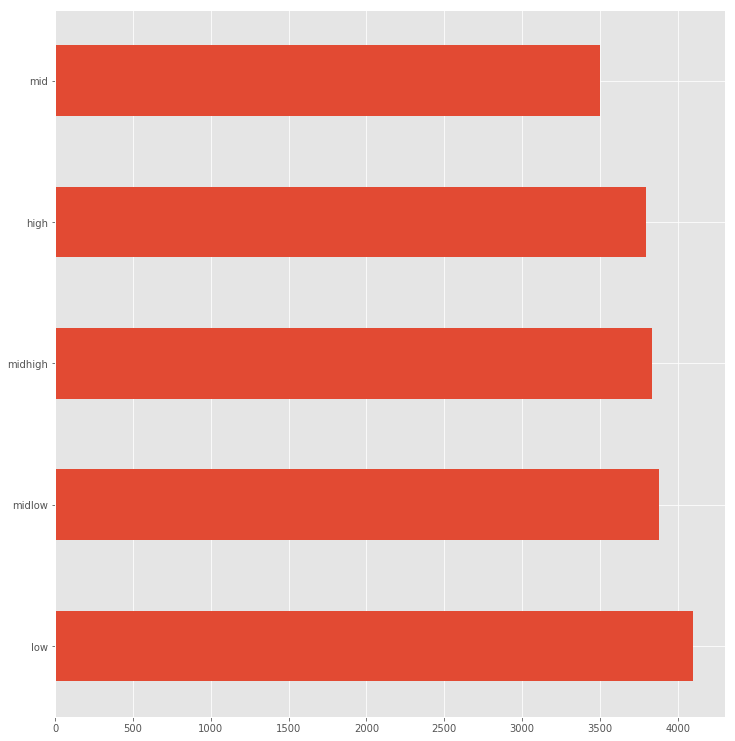

In [21]:
fig_size = [12, 13]
plt.rcParams["figure.figsize"] = fig_size

series = df["ARPCIncome"].astype('category')
gino = series.value_counts()
gino.plot.barh()
print ""

In [22]:
s = pandas.Series([1,2,3,4,5,6,7,90,20])
G = pandas.cut(s, 3, labels=["low", "medium", "high"], include_lowest=True)

G

0     low
1     low
2     low
3     low
4     low
5     low
6     low
7    high
8     low
dtype: category
Categories (3, object): [low < medium < high]

In [23]:
df_crimes_and_census

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
0,371190032011003,CHARLOTTE WOOD APARTMENTS,CAROLINA FIRST AID & SAFETY,WILDWOOD APARTMENTS,MT ZION HOLINESS CHURCH,mid,22.5136,93.0147,30.6122,20.3501,0.000151339,7.42574,0.549505,8.91089,14,38,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Apartment/Duplex Private Res,Indoors,01/01/2010 0005,SCALEYBARK
12,371190015041006,UNITED TREATMENT FACILITY,LINKS AT CITI SIDE,STRAIGHT LINE PAVEMENT MARKING,JAMES D MCDUFFIE AGENT,mid,14.6895,80.3054,28.8553,28.1577,0.00013986,54.1667,0.53125,0,72.7273,36.3636,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Apartment/Duplex Private Res,Outdoors,01/01/2010 0110,CITISIDE
15,371190001001020,hotels,ILLUM'E,OMNI CHARLOTTE HOTEL,THE RITZ CARLTON HOTEL COMPANY LLC,high,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Weapon Law Violations,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Open Area,Street/Highway,Outdoors,01/01/2010 0118,COLLEGE
17,371190019113000,INTERACTIVE COMMUNICATIONS,TODDLETOWN KIDS INC,HOMEPLACE MASONRY INC,G T M GENERAL CONTRACTING INC,mid,7.36961,72.3454,28.0559,14.4354,0.000199563,37.3072,0.685781,4.76858,43.9689,33.0739,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Private Residence,Indoors,01/01/2010 0140,WALTERBORO
18,371190051001003,CHARLOTTE MANOR LLC,NORTHEASTERN PLUMBING CO,MURPHY'S HOME REMODELING,ST JAMES HOLINESS CHURCH,low,11.138,54.6798,50.2427,10.4126,0,0,0,0,0,0,Simple Assault,Completed,Further Investigation,Open,Residential,Private Residence,Outdoors,01/01/2010 0141,MCARTHUR
22,371190042003001,ENDERLY PARK RECREATION CTR,GOOD HOPE MISSIONARY BAPTIST,KAMIT NATURAL FOODS,PARKVIEW,low,21.7842,39.4886,69.378,6.03774,0.000137641,72.5,0.455,10,46.6667,26.6667,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Private Residence,Indoors,01/01/2010 0148,CLAY
23,371190005003013,GREENS LUNCH INC,V LOUNGE,drinking,TORRENCE DOCUMENT SERVICES,midhigh,22.045,79.1171,48.3929,52.7738,0.000282275,43.2432,0.520088,2.7027,87.5,25,Damage/Vandalism Of Property,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Bar/Tavern/Nightclub,Outdoors,01/01/2010 0149,4TH
27,371190038023020,FITNESS TOGETHER,DMR ARCHITECT,DUCKSWORTHS CHEESESTEAKERY,CC SELF TAN LLC,midlow,0,74.2857,12.7072,0,0.000106519,55.814,0.51271,0,47.3684,21.0526,Affray,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Bar/Tavern/Nightclub,Parking Lot,01/01/2010 0200,WOODLAWN
29,371190001001020,COYOTE UGLY SALOON,drinking,MAID IN MECKLENBURG,TRYON HOUSE APARTMENTS,high,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Commercial Place,Restaurant/Diner/Coffee Shop,Indoors,01/01/2010 0208,COLLEGE
31,371190013001011,WEESIES HOME CARE SERVICES INC,A MILLER ROOFING,GUARANTEED ROOFING CO,A MILLER CLEANING SVC,mid,13.1707,71.9573,36.8247,19.5424,0.000165663,27.2727,0.512397,0,77.7778,16.6667,Aggravated Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Private Residence,Outdoors,01/01/2010 0209,MEADOW


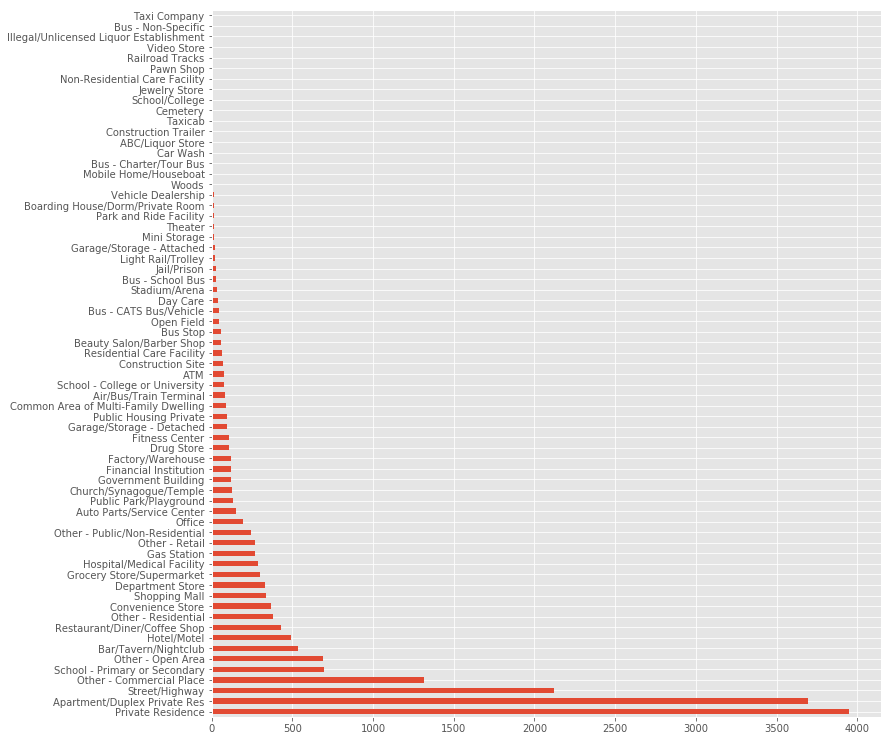

In [24]:
fig_size = [12, 13]
plt.rcParams["figure.figsize"] = fig_size

series = df_crimes_and_census["Place2"].astype('category')
gino = series.value_counts()
gino.plot.barh()
print ""

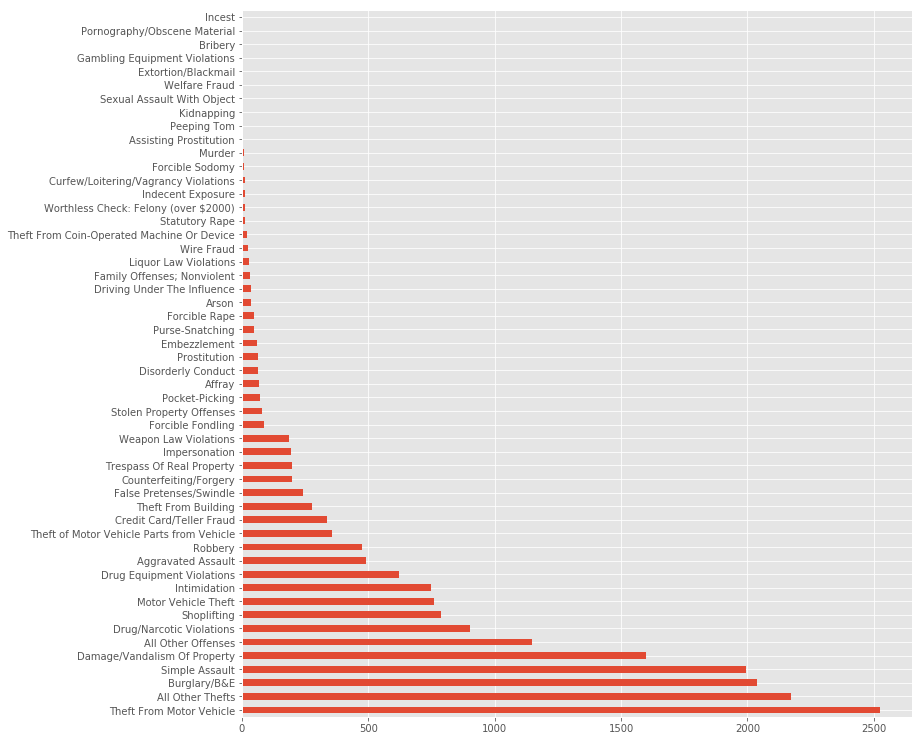

In [25]:
fig_size = [12, 13]
plt.rcParams["figure.figsize"] = fig_size

series = df_crimes_and_census["NIBRSclass"].astype('category')
gino = series.value_counts()
gino.plot.barh()
print ""

In [26]:
# discretize census data
# check if there are no typos on other params 